### Import libraries and datasets:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [3]:
csv_fts = "FTS Historical Data.csv"
csv_mwg = "MWG Historical Data.csv"
csv_vic = "VIC Historical Data.csv"



df_fts = pd.read_csv(csv_fts, thousands=',')
df_mwg = pd.read_csv(csv_mwg, thousands=',')
df_vic = pd.read_csv(csv_vic, thousands=',')

### Dataset 1: FTS

- Cast Date column to datetime type
- Sort data ascending by Date

In [4]:
df_fts['Date'] = pd.to_datetime(df_fts['Date'])
df_fts = df_fts.sort_values(by='Date', ascending=True)
df_fts.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,5788,5859,5859,5788,103.55K,-0.0121
1358,2018-01-03,5954,5765,5977,5741,245.02K,0.0286
1357,2018-01-04,6025,5954,6143,5907,167.80K,0.0119
1356,2018-01-05,5883,5977,6048,5883,113.88K,-0.0235
1355,2018-01-08,6001,5859,6001,5765,63.36K,0.0201


- Split Price data
- Reset index

In [5]:
df_price = df_fts[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,5788
1,5954
2,6025
3,5883
4,6001


- Scale data between 0 and 1:

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.000000
1,0.003602
2,0.005143
3,0.002061
4,0.004622


- Split data into train, test, val (7 - 2 - 1):

In [7]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


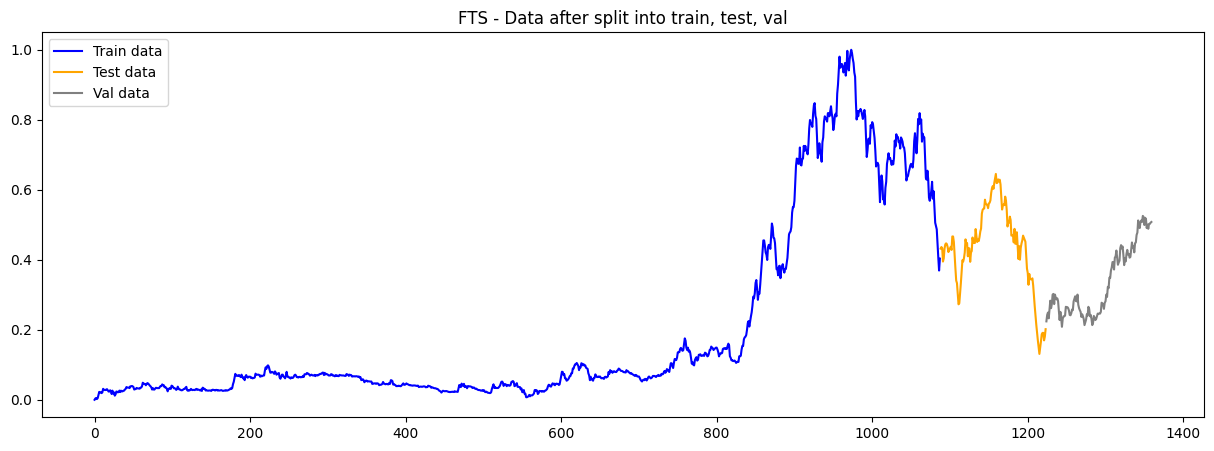

In [8]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('FTS - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [9]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)]
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [10]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Model training:

Kernel: linear, poly, rbf, sigmoid, precomputed

In [12]:
model_svr = SVR(kernel='linear')
model_svr.fit(x_train, y_train)

SVR(kernel='linear')

- Model Prediction on test, val (one-step prediction):

In [13]:
y_pred_test = model_svr.predict(x_test)
y_pred_val = model_svr.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [14]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags)
    y_hat = model_svr.predict(x_input)
    temp_input.append(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.append(y_hat[0])
    i += 1


In [15]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[26077.49121262],
       [26546.45854523],
       [26842.59788986],
       [27085.15255827],
       [27294.54159854],
       [27431.32219029],
       [27613.06181282],
       [27821.46346349],
       [28104.73030419],
       [28412.90389052],
       [28535.01405138],
       [28658.08455982],
       [28886.59467312],
       [29138.55510879],
       [29395.66628699],
       [29493.98062299],
       [29612.04721715],
       [29869.07860996],
       [30154.19552615],
       [30556.19572782],
       [30844.23897314],
       [31128.5504193 ],
       [31394.9281254 ],
       [31488.56504541],
       [31598.90075185],
       [31741.72198842],
       [31881.43949913],
       [32040.94134627],
       [32133.16169824],
       [32232.14411828]])

- Model evaluating (RMSE - MAPE - MSLE):

In [16]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 28060.3082
Validating RMSE: 23384.9304
Predicting 30 days RMSE: 29525.2725

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 96.8586
Validating MSLE: 94.6704
Predicting 30 days MSLE: 97.9781


- Prediction plotting:

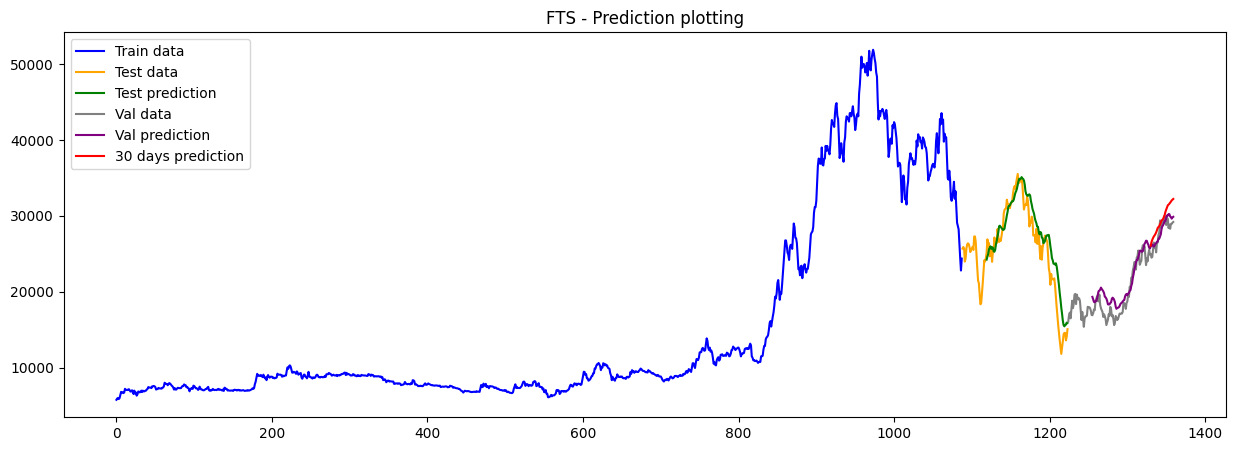

In [17]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('FTS - Prediction plotting')
plt.show()

### Dataset 2: MWG

In [18]:
df_mwg['Date'] = pd.to_datetime(df_mwg['Date'])
df_mwg = df_mwg.sort_values(by='Date', ascending=True)
df_mwg.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,31276,31039,31394,31039,2.27M,0.01
1358,2018-01-03,31892,31323,32034,31276,4.53M,0.02
1357,2018-01-04,31963,31773,32081,31750,2.71M,0.00
1356,2018-01-05,31608,31987,31987,31465,2.93M,-0.01
1355,2018-01-08,31110,31394,31513,31039,3.01M,-0.02


- Split Price data
- Reset index

In [19]:
df_price = df_mwg[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,31276
1,31892
2,31963
3,31608
4,31110


- Scale data between 0 and 1:

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.200020
1,0.210221
2,0.211397
3,0.205518
4,0.197271


- Split data into train, test, val (7 - 2 - 1):

In [21]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


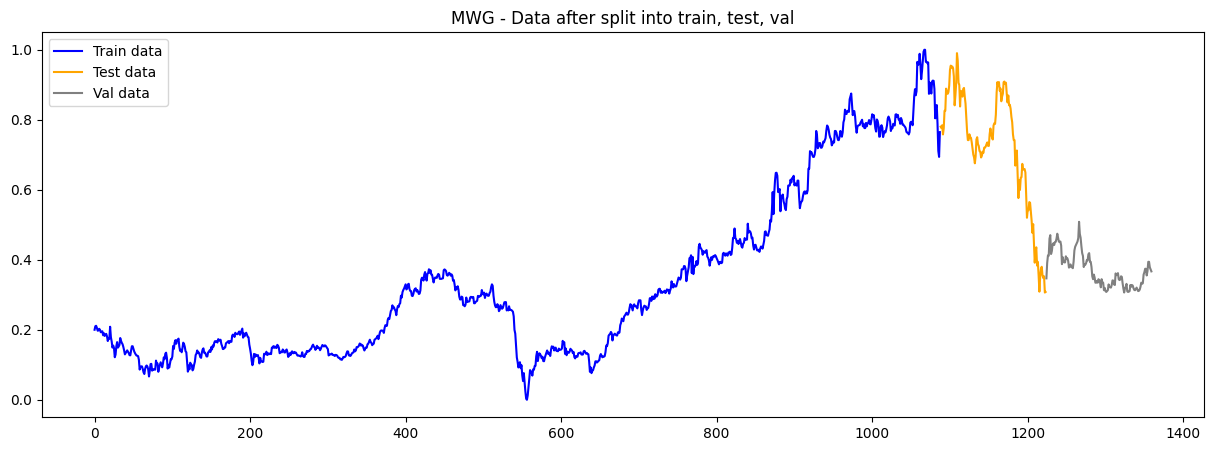

In [22]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('MWG - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [23]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)]
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [24]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Model training:

In [25]:
model_svr = SVR(kernel='linear')
model_svr.fit(x_train, y_train)

SVR(kernel='linear')

- Model Prediction on test, val (one-step prediction):

In [26]:
y_pred_test = model_svr.predict(x_test)
y_pred_val = model_svr.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [27]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags)
    y_hat = model_svr.predict(x_input)
    temp_input.append(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.append(y_hat[0])
    i += 1


In [28]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[38824.27828595],
       [38850.81960413],
       [38805.77762925],
       [38835.46943791],
       [39051.3255785 ],
       [39255.4653029 ],
       [39470.21720358],
       [39684.61279626],
       [39955.4129753 ],
       [40228.24474695],
       [40450.43566502],
       [40876.16116583],
       [41321.49312224],
       [41674.73015031],
       [41905.6888654 ],
       [42142.08280958],
       [42434.61494285],
       [42722.26367327],
       [43016.08497296],
       [43229.01573441],
       [43396.87922868],
       [43515.79717015],
       [43634.94799007],
       [43764.8765724 ],
       [43877.70266268],
       [44025.75219551],
       [44078.25241717],
       [44111.15595863],
       [44164.29700514],
       [44231.5251654 ]])

- Model evaluating (RMSE - MAPE - MSLE):

In [29]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 62619.7306
Validating RMSE: 41663.5138
Predicting 30 days RMSE: 41764.1259

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 110.4436
Validating MSLE: 106.6935
Predicting 30 days MSLE: 107.0324


- Prediction plotting:

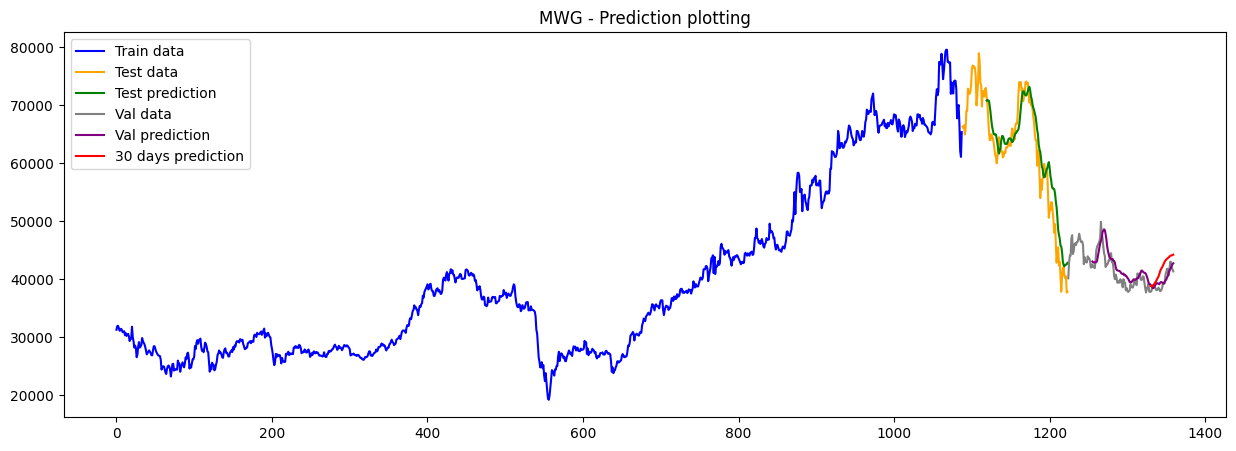

In [30]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('MWG - Prediction plotting')
plt.show()

- Prediction plotting:

### Dataset 3: VIC

In [31]:
df_vic['Date'] = pd.to_datetime(df_vic['Date'])
df_vic = df_vic.sort_values(by='Date', ascending=True)
df_vic.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,64628,64132,64876,63967,1.74M,1.16%
1358,2018-01-03,66529,65702,68760,64959,6.07M,2.94%
1357,2018-01-04,66942,67355,68678,66529,3.55M,0.62%
1356,2018-01-05,66116,66942,66942,65289,3.42M,-1.23%
1355,2018-01-08,66364,66116,67686,65372,4.81M,0.38%


- Split Price data
- Reset index

In [32]:
df_price = df_vic[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,64628
1,66529
2,66942
3,66116
4,66364


- Scale data between 0 and 1:

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.182297
1,0.206826
2,0.212155
3,0.201497
4,0.204697


- Split data into train, test, val (7 - 2 - 1):

In [34]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


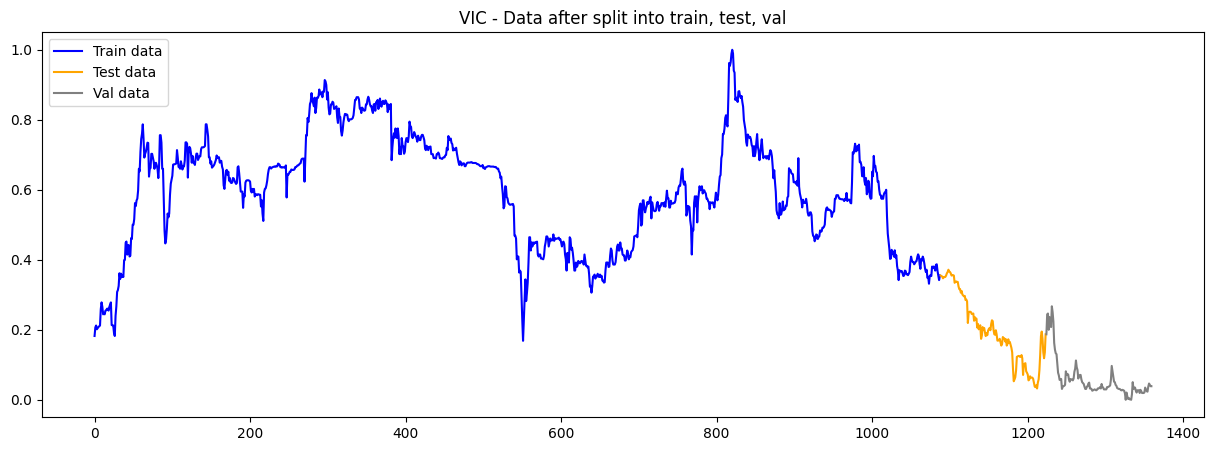

In [35]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('VIC - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [36]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)]
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [37]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Model training:

In [38]:
model_svr = SVR(kernel='linear')
model_svr.fit(x_train, y_train)

SVR(kernel='linear')

- Model Prediction on test, val (one-step prediction):

In [39]:
y_pred_test = model_svr.predict(x_test)
y_pred_val = model_svr.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [40]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags)
    y_hat = model_svr.predict(x_input)
    temp_input.append(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.append(y_hat[0])
    i += 1


In [41]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[ 60114.96393352],
       [ 64644.3686357 ],
       [ 68604.37721707],
       [ 72462.59993085],
       [ 76356.59259873],
       [ 80349.23438218],
       [ 83970.11970304],
       [ 87701.03175024],
       [ 92248.9261948 ],
       [ 96710.98466015],
       [101195.10750844],
       [105777.1410357 ],
       [110354.12488861],
       [114704.45792173],
       [118739.67766807],
       [122190.53429646],
       [125145.42253438],
       [127972.35007689],
       [130454.37772356],
       [132861.81386196],
       [135497.09320873],
       [137816.65961451],
       [139800.49001544],
       [141604.9956462 ],
       [143747.9371569 ],
       [145903.22161308],
       [147984.50459736],
       [149335.6372163 ],
       [150212.28676058],
       [150596.14363929]])

- Model evaluating (RMSE - MAPE - MSLE):

In [42]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 69090.9692
Validating RMSE: 61992.2397
Predicting 30 days RMSE: 117400.7734

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 120.8696
Validating MSLE: 120.9416
Predicting 30 days MSLE: 134.1952


- Prediction plotting:

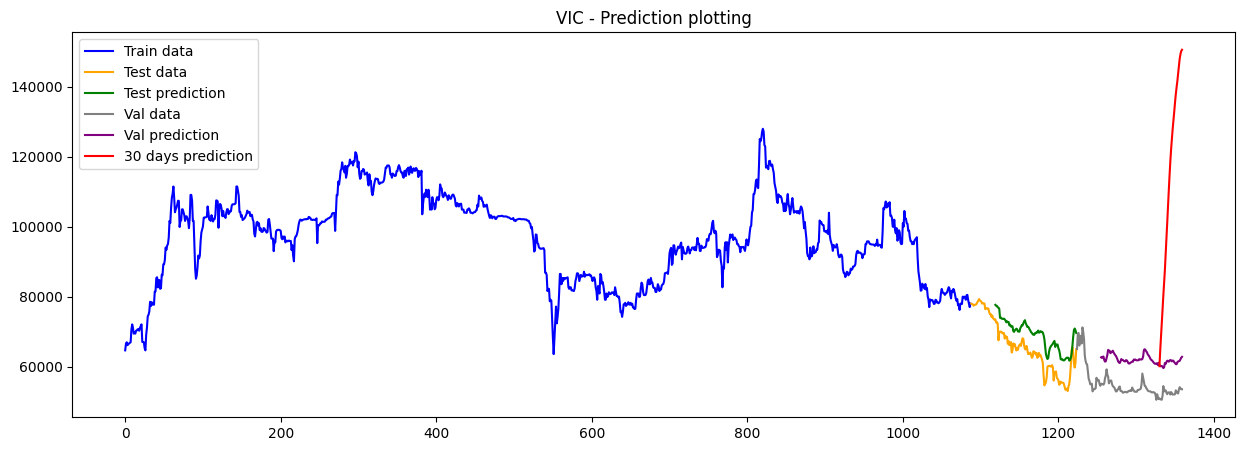

In [43]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('VIC - Prediction plotting')
plt.show()